<a href="https://colab.research.google.com/github/Likelipop/See_image_processing/blob/main/Week6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Application of Fourier Transform in Digital Image Processing: Part 2**

In [ ]:
import numpy as np
import pandas as pd
import cv2
import pywt
import os
from matplotlib import pyplot as plt
import matplotlib.cm as cm
import matplotlib.gridspec as gridspec
from pylab import imread
from skimage.color import rgb2gray
import gdown

In [ ]:
gdown.download('https://drive.google.com/uc?export=download&id=1JDHHv5RED6cvOHuJKq_MPV2ftV2aTlar', 'brandenburg.jpg', quiet=False)

Downloading...
From: https://drive.google.com/uc?export=download&id=1JDHHv5RED6cvOHuJKq_MPV2ftV2aTlar
To: /content/brandenburg.jpg
100%|██████████| 24.8k/24.8k [00:00<00:00, 37.8MB/s]


'brandenburg.jpg'

In [ ]:
fil_path = '/content'  # Base directory path for image files
imgbridge = 'brandenburg.jpg'  # Filename of the bridge image

In [ ]:
def Image3Dto2D(image):
    """
    Convert a 3D image (color) to a 2D image (grayscale).

    Parameters:
        image (ndarray): Input image, which can be 2D (grayscale) or 3D (color).

    Returns:
        image_2D (ndarray): Grayscale image as a 2D array.
    """
    # Check if the image has at least 3 dimensions (color image)
    if len(image.shape) >= 3:
        # Convert the 3D color image to grayscale using OpenCV's cvtColor function
        image_2D = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    else:
        # If the image is already 2D (grayscale), create a copy of it
        image_2D = image.copy()

    return image_2D

In [ ]:
def ShowImage(ImageList, nRows=1, nCols=2, WidthSpace=0.00, HeightSpace=0.00):
    """
    Display a list of images in a grid layout using Matplotlib.

    Parameters:
        ImageList (list): List of images to be displayed.
        nRows (int): Number of rows in the grid layout. Default is 1.
        nCols (int): Number of columns in the grid layout. Default is 2.
        WidthSpace (float): Horizontal space between grid cells. Default is 0.00.
        HeightSpace (float): Vertical space between grid cells. Default is 0.00.
    """
    # Initialize a GridSpec object for the grid layout with specified rows and columns
    gs = gridspec.GridSpec(nRows, nCols)

    # Update the grid spacing with the provided width and height spacing
    gs.update(wspace=WidthSpace, hspace=HeightSpace)  # Adjust spacing between plots.

    # Set the figure size
    plt.figure(figsize=(20, 10))

    # Loop through the list of images
    for i in range(len(ImageList)):
        # Create a subplot for the current image using GridSpec
        ax1 = plt.subplot(gs[i])

        # Remove tick labels for a cleaner display
        ax1.set_xticklabels([])
        ax1.set_yticklabels([])

        # Set the aspect ratio to 'equal' to preserve image dimensions
        ax1.set_aspect('equal')

        # Create another subplot using standard indexing
        plt.subplot(nRows, nCols, i + 1)

        # Copy the image to avoid modifying the original
        image = ImageList[i].copy()

        # Check if the image is grayscale (2D array)
        if len(image.shape) < 3:
            # Display grayscale image using the appropriate colormap
            plt.imshow(image, plt.cm.gray)
        else:
            # Display color image
            plt.imshow(image)

        # Add a title to the image, e.g., "Image 0", "Image 1", etc.
        plt.title("Image " + str(i))

        # Turn off axes for a cleaner display
        plt.axis('off')

    # Show all the images
    plt.show()


In [ ]:
def DFT_Transformation(image):
    """
    Perform Discrete Fourier Transform (DFT) on an image and compute its magnitude spectrum.

    Parameters:
        image (ndarray): Input image, can be 2D (grayscale) or 3D (color).

    Returns:
        magnitude_spectrum (ndarray): The magnitude spectrum of the transformed image.
        dft_shift (ndarray): The shifted DFT result (frequency domain representation).
    """
    # Convert the image to 2D grayscale if it is a color image
    img = Image3Dto2D(image)

    # Convert the image to float32 format (required for DFT)
    img_float32 = np.float32(img)

    # Apply Discrete Fourier Transform (DFT) to the image
    dft = cv2.dft(img_float32, flags=cv2.DFT_COMPLEX_OUTPUT)

    # Shift the zero-frequency component to the center of the frequency domain
    dft_shift = np.fft.fftshift(dft)

    # Compute the magnitude spectrum (log-scaled for visualization)
    magnitude_spectrum = 20 * np.log(cv2.magnitude(dft_shift[:, :, 0], dft_shift[:, :, 1]))

    return magnitude_spectrum, dft_shift


In [ ]:
def InverseDFTWithMask(dft_shift, mask):
    """
    Apply a mask to the frequency domain representation of an image and perform an inverse DFT.

    Parameters:
        dft_shift (ndarray): The shifted DFT (frequency domain) representation of the image.
        mask (ndarray): The mask to apply in the frequency domain.

    Returns:
        image_inverse (ndarray): The reconstructed image in the spatial domain after applying the mask.
    """
    # Apply the mask to the frequency domain representation
    fshift = dft_shift * mask

    # Perform an inverse shift to move the zero-frequency component back to its original position
    f_ishift = np.fft.ifftshift(fshift)

    # Perform the inverse Discrete Fourier Transform (IDFT)
    img_inverse = cv2.idft(f_ishift)

    # Compute the magnitude of the spatial domain representation
    image_inverse = cv2.magnitude(img_inverse[:, :, 0], img_inverse[:, :, 1])

    return image_inverse

In [ ]:
def get_actual_file_size(image_path):
    """
    Get the actual file size of the image stored on the disk.

    Args:
        image_path (str): The path to the image file.

    Returns:
        float: The actual file size (in KB).
    """
    file_size = os.path.getsize(image_path)  # Get the file size on disk (in bytes)
    return f"The actual file size is: {file_size / 1024 :.2f} KB" # Convert to KB

In [ ]:
# Read Image
image_color = imread(imgbridge)
# Convert Image into Gray
image_gray = cv2.cvtColor(image_color, cv2.COLOR_RGB2GRAY)

In [ ]:
image_dft_frequency, dft_shift = DFT_Transformation(image_gray)

##Bandreject and Bandpass filters in image processing

###Bandpass filters

In [ ]:
def ApplyCenterSquareMasMasKBandPass(dft_shift, size_small,size_big,dim):
    """
    Apply a center square mask to the frequency domain representation of an image.

    Parameters:
        dft_shift (ndarray): The shifted DFT (frequency domain) representation of the image.
        size (int): Half the side length of the square mask to be applied.

    Returns:
        masked_dft_shift (ndarray): The frequency domain representation after applying the mask.
        mask (ndarray): The mask applied to the frequency domain representation.
    """
    # Get the dimensions of the DFT
    rows, cols = dft_shift.shape[:2]
    crow, ccol = rows // 2, cols // 2  # Calculate the center of the frequency domain

    # Create a zero-filled mask with the same size as the frequency domain representation
    mask = np.zeros((rows, cols, 2), np.uint8)

    # Set a center square to 1
    mask_lowpass = mask.copy()
    mask_lowpass[crow - size_small:crow + size_small, ccol - size_small:ccol + size_small] = 1
    mask_centralpass = mask.copy()
    mask_centralpass[crow - size_small - size_big:crow + size_small + size_big,ccol - size_small - size_big:ccol + size_small + size_big] = 1
    maskbandpass = mask_centralpass - mask_lowpass

    # Apply the mask to the frequency domain representation
    masked_dft_shift = dft_shift * maskbandpass[:,:,dim]

    return masked_dft_shift, maskbandpass

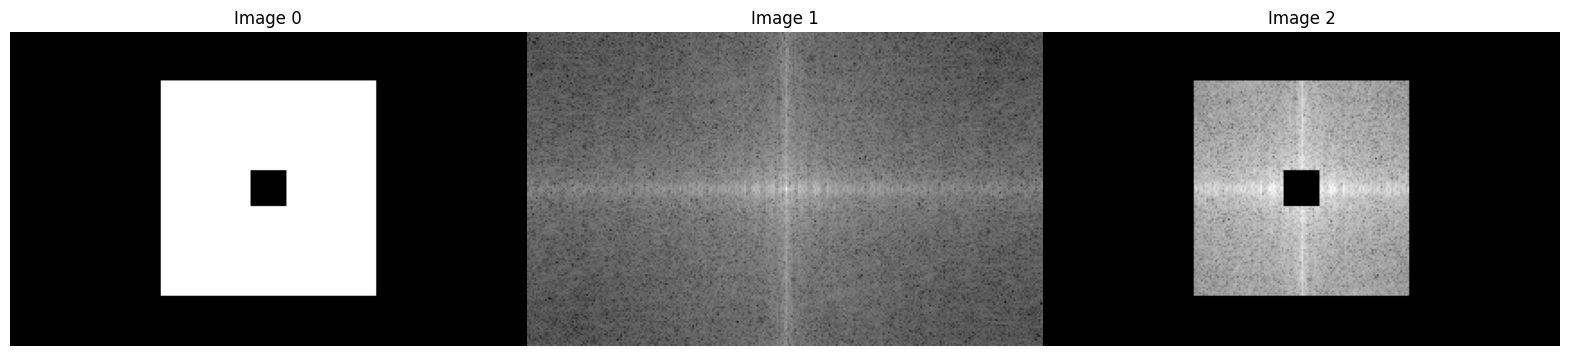

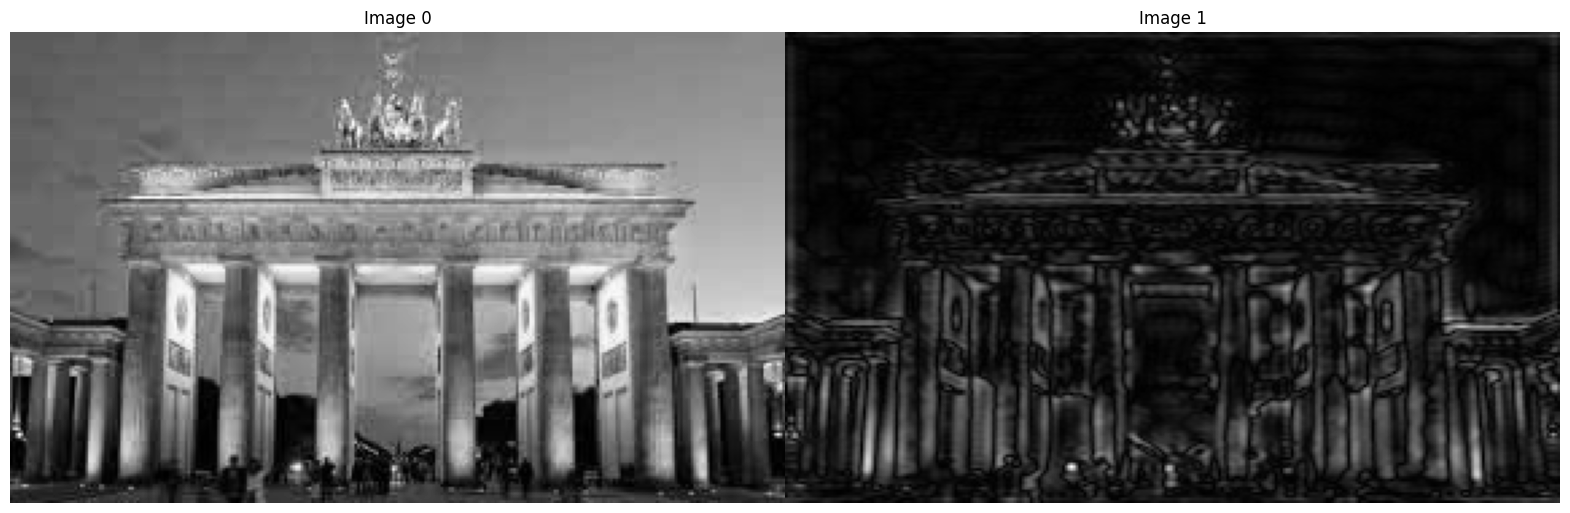

In [ ]:
rows, cols = image_gray.shape
crow,ccol = (int)(rows/2) , (int)(cols/2)

# create a mask first, center square is 1, remaining all zeros

image_dft_frequency_crop,maskbandreject = ApplyCenterSquareMasMasKBandPass(image_dft_frequency,size_small = 10,size_big=50,dim = 0)

# apply mask and inverse DFT

image_inverse = InverseDFTWithMask(dft_shift, maskbandreject)

ShowImage([maskbandreject[:,:,0], image_dft_frequency, image_dft_frequency_crop], 1, 3)
ShowImage([image_gray, image_inverse], 1, 2)

###Bandreject filters

In [ ]:
def ApplyCenterSquareMasKBandReject(dft_shift,size_small,size_big,dim):
    """
    Apply a center square mask to the frequency domain representation of an image.

    Parameters:
        dft_shift (ndarray): The shifted DFT (frequency domain) representation of the image.
        size (int): Half the side length of the square mask to be applied.

    Returns:
        masked_dft_shift (ndarray): The frequency domain representation after applying the mask.
        mask (ndarray): The mask applied to the frequency domain representation.
    """
    # Get the dimensions of the DFT
    rows, cols = dft_shift.shape[:2]
    crow, ccol = rows // 2, cols // 2  # Calculate the center of the frequency domain

    # Create a zero-filled mask with the same size as the frequency domain representation
    mask = np.zeros((rows, cols, 2), np.uint8)
    mask_universe = np.ones((rows, cols, 2), np.uint8)
    # Set a center square to 1
    mask_lowpass = mask.copy()
    mask_lowpass[crow - size_small:crow + size_small, ccol - size_small:ccol + size_small] = 1
    mask_centralpass = mask.copy()
    mask_centralpass[crow - size_small - size_big:crow + size_small + size_big,ccol - size_small - size_big:ccol + size_small + size_big] = 1
    maskbandpass = mask_centralpass - mask_lowpass
    maskbandreject = mask_universe - maskbandpass
    # Apply the mask to the frequency domain representation
    masked_dft_shift = dft_shift * maskbandreject[:,:,dim]

    return masked_dft_shift, maskbandreject

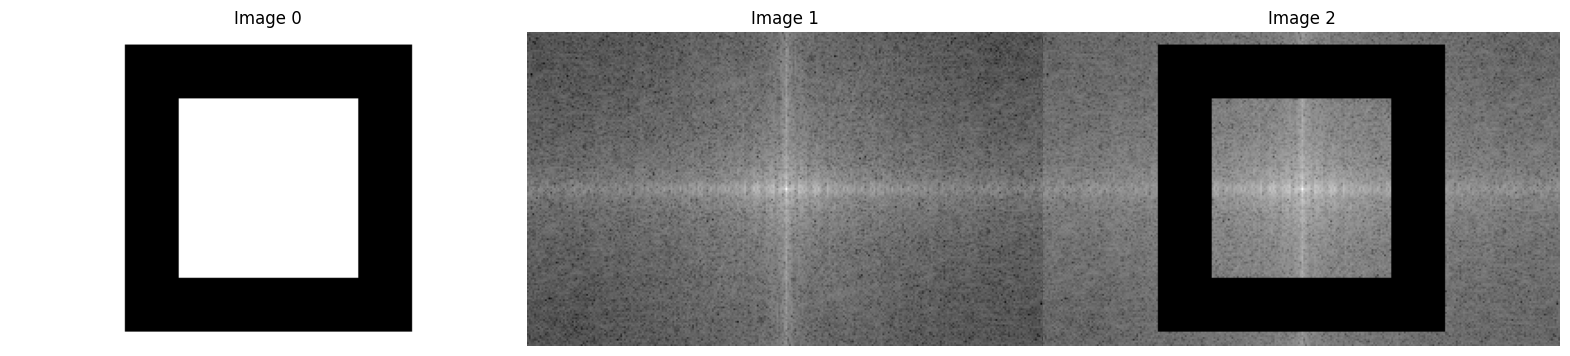

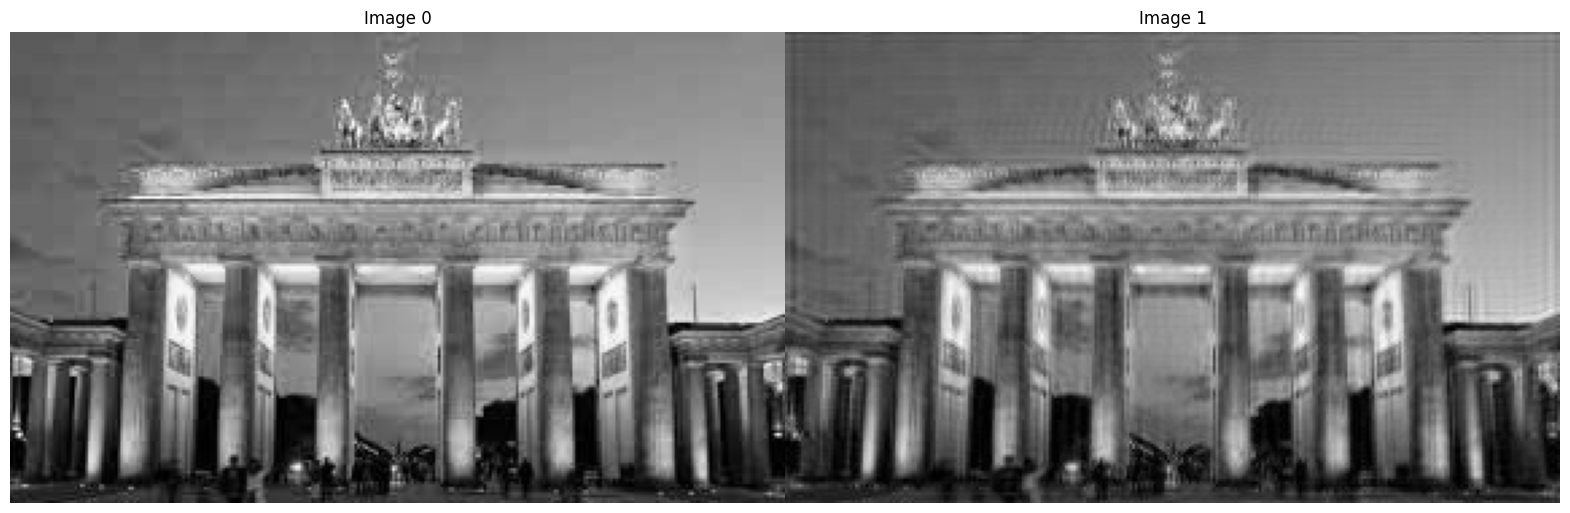

In [ ]:
rows, cols = image_gray.shape
crow,ccol = (int)(rows/2) , (int)(cols/2)

# create a mask first, center square is 1, remaining all zeros

image_dft_frequency_crop,maskbandreject = ApplyCenterSquareMasKBandReject(image_dft_frequency,size_small = 50,size_big=30,dim = 0)

# apply mask and inverse DFT

image_inverse = InverseDFTWithMask(dft_shift, maskbandreject)

ShowImage([maskbandreject[:,:,0], image_dft_frequency, image_dft_frequency_crop], 1, 3)
ShowImage([image_gray, image_inverse], 1, 2)

##Exploring Image Compression with Fourier Tranform and Wavelet Traform

###Fourier Tranform

Fourier Transform decomposes an image into its frequency components. High-frequency components, representing details and edges, can be reduced without losing significant information.

In [ ]:
def ApplyCenterSquareMask2(dft_shift, size,dim):
    """
    Apply a center square mask to the frequency domain representation of an image.

    Parameters:
        dft_shift (ndarray): The shifted DFT (frequency domain) representation of the image.
        size (int): Half the side length of the square mask to be applied.

    Returns:
        masked_dft_shift (ndarray): The frequency domain representation after applying the mask.
        mask (ndarray): The mask applied to the frequency domain representation.
    """
    # Get the dimensions of the DFT
    rows, cols = dft_shift.shape[:2]
    crow, ccol = rows // 2, cols // 2  # Calculate the center of the frequency domain

    # Create a zero-filled mask with the same size as the frequency domain representation
    mask = np.zeros((rows, cols, 2), np.uint8)

    # Set a center square to 1
    mask[crow - size:crow + size, ccol - size:ccol + size] = 1
    mask = 1 -mask
    # Apply the mask to the frequency domain representation
    masked_dft_shift = dft_shift * mask[:,:,dim]

    return masked_dft_shift, mask

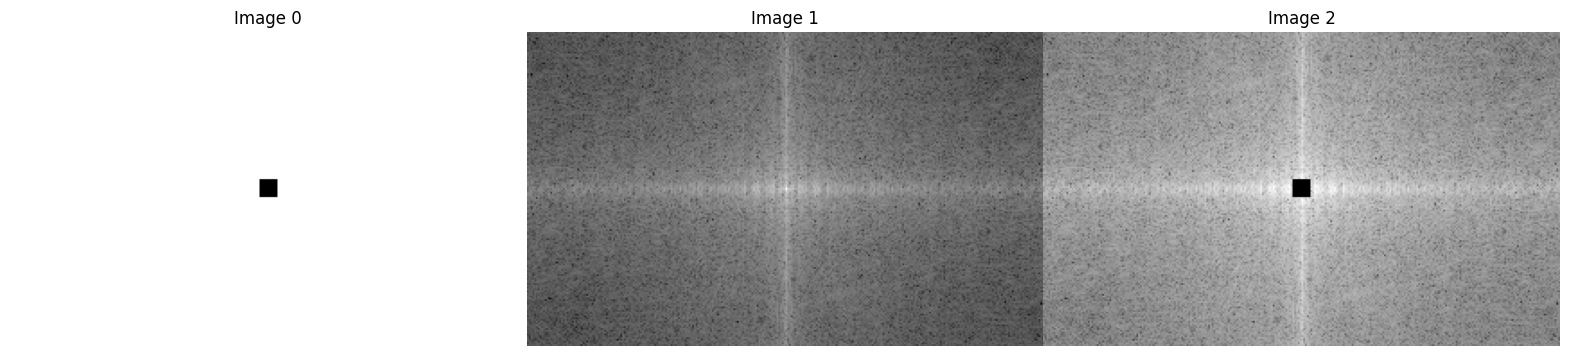

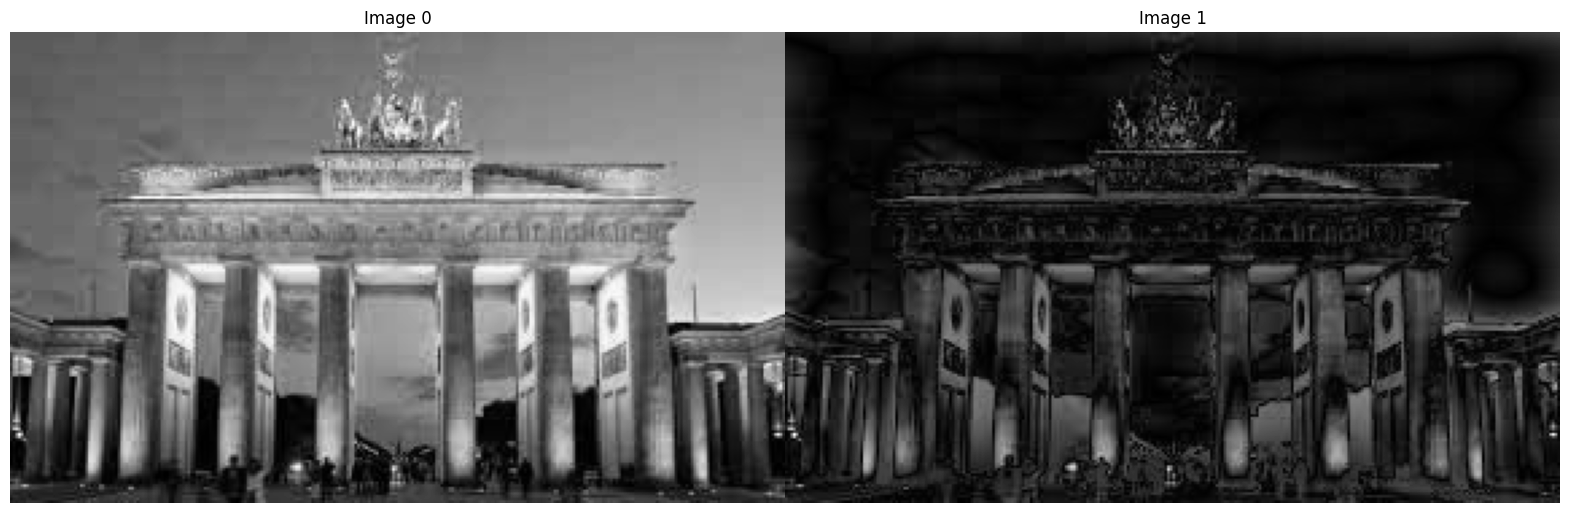

In [ ]:
rows, cols = image_gray.shape
crow,ccol = (int)(rows/2) , (int)(cols/2)

# create a mask first, center square is 1, remaining all zeros

image_dft_frequency_crop,maskbandreject = ApplyCenterSquareMask2(image_dft_frequency,size = 5,dim = 0)

# apply mask and inverse DFT

image_inverse = InverseDFTWithMask(dft_shift, maskbandreject)

ShowImage([maskbandreject[:,:,0], image_dft_frequency, image_dft_frequency_crop], 1, 3)
ShowImage([image_gray, image_inverse], 1, 2)

In [ ]:
cv2.imwrite('compressed_image_Fourier.jpg', image_inverse)

True

###Wavelet Tranform

Wavelet Transform provides a multi-resolution analysis of an image. It decomposes the image into approximation and detail coefficients, allowing for efficient compression.

In [ ]:

def calculate_wavelet_coeffs(image, wavelet='bior1.3'):
    """
    Compute the wavelet coefficients using 2D Discrete Wavelet Transform (DWT2) for the input image.

    Parameters:
    - image: numpy array representing the input image.
    - wavelet: name of the wavelet to be used (default is 'bior1.3').

    Returns:
    - cA: Approximation coefficients.
    - cH: Horizontal detail coefficients.
    - cV: Vertical detail coefficients.
    - cD: Diagonal detail coefficients.
    """
    coeffs = pywt.dwt2(image, wavelet)  # Perform 2D DWT on the input image
    cA, (cH, cV, cD) = coeffs          # Decompose the coefficients into components
    return cA, cH, cV, cD              # Return the computed coefficients


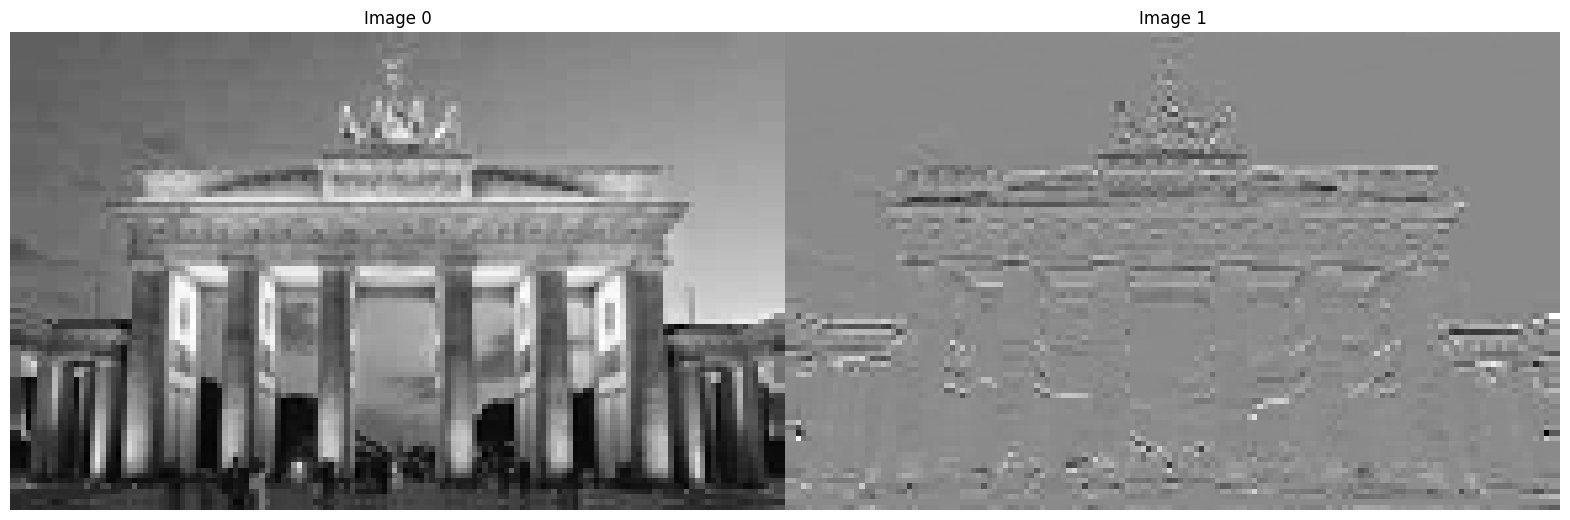

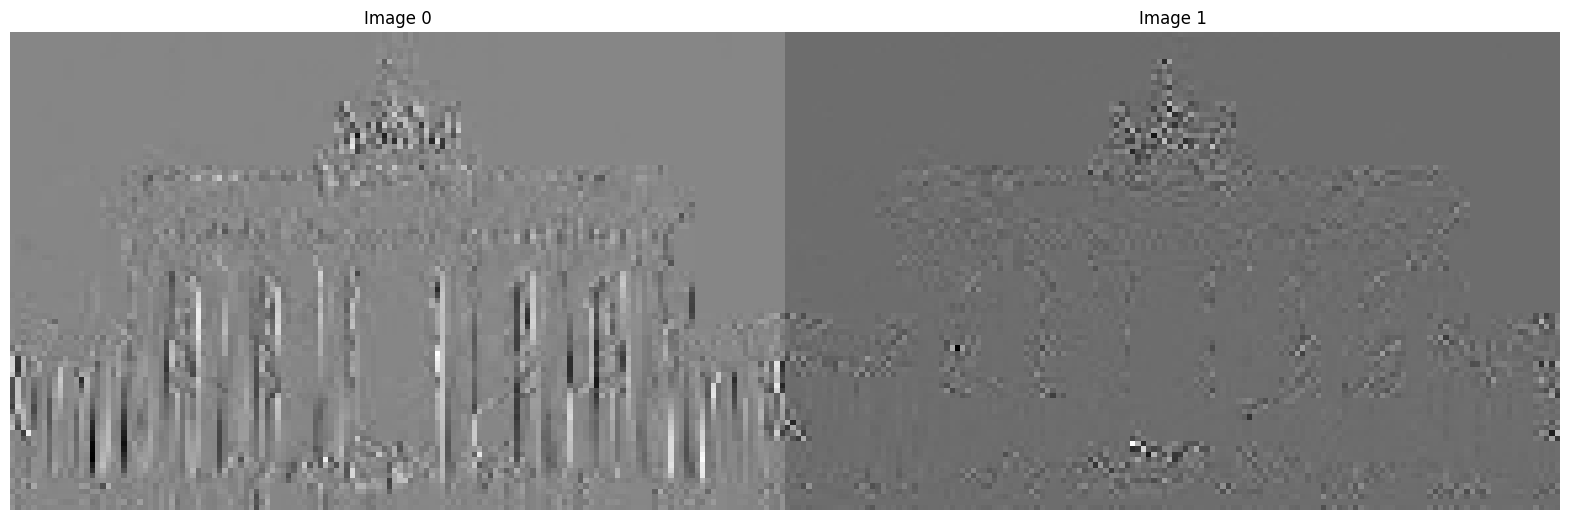

In [ ]:
cA, cH, cV, cD = calculate_wavelet_coeffs(image_gray)

ShowImage([cA, cH], 1, 2)
ShowImage([cV, cD], 1, 2)

Adjust the threshold to discard less significant coefficients and achieve compression.

In [ ]:
def compress_image_with_threshold(coeffs, threshold, wavelet='bior1.3'):
    """
    Compresses an image by applying thresholding to its wavelet coefficients.

    Parameters:
    coeffs (tuple): Wavelet coefficients of the image as (cA, (cH, cV, cD)).
    threshold (float): Thresholding limit to apply on the coefficients.
    wavelet (str): Wavelet type to use for reconstruction. Default is 'bior1.3'.

    Returns:
    numpy.ndarray: Compressed image after inverse wavelet transform.
    """
    # Unpack the wavelet coefficients
    cA, (cH, cV, cD) = coeffs

    # Apply soft thresholding to the approximation and horizontal detail coefficients
    cA_thresholded = pywt.threshold(cA, threshold, mode='soft')
    cH_thresholded = pywt.threshold(cH, threshold, mode='soft')

    # Repack the thresholded coefficients
    coeffs_thresholded = (cA_thresholded, (cH_thresholded, cV, cD))

    # Perform the inverse wavelet transform to reconstruct the compressed image
    img_compressed = pywt.idwt2(coeffs_thresholded, wavelet)

    return img_compressed

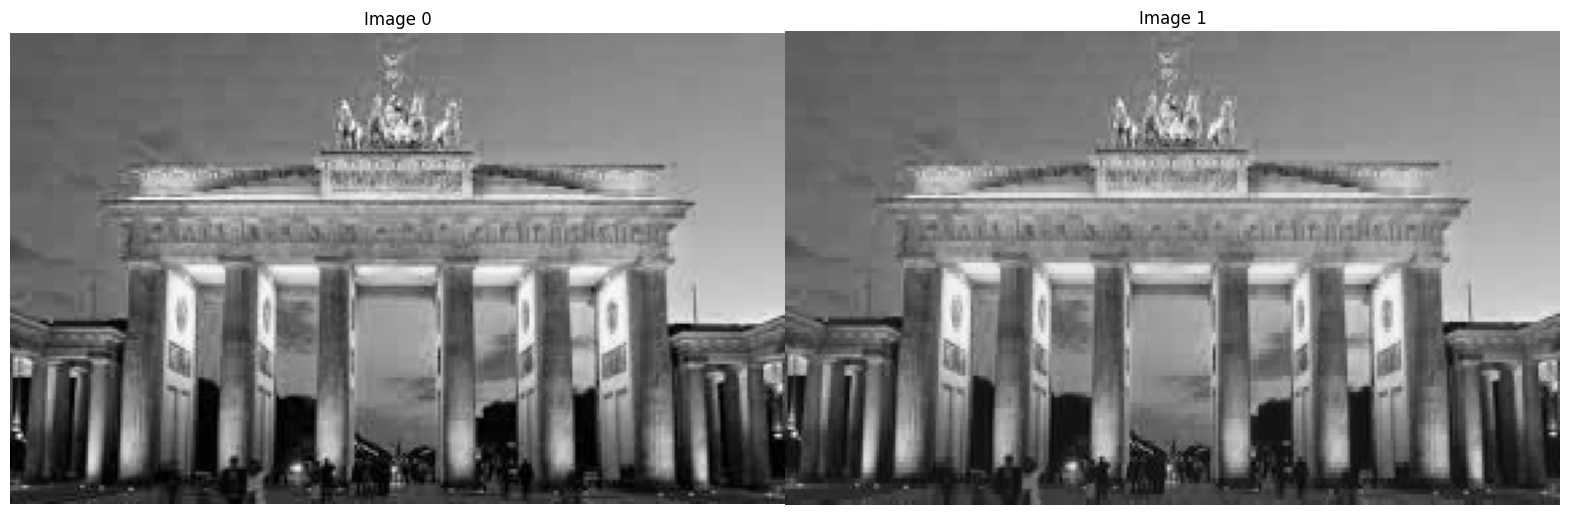

In [ ]:
compressed_image = compress_image_with_threshold(coeffs = (cA, (cH, cV, cD)), threshold = 20)
ShowImage([image_gray, compressed_image], 1, 2)

In [ ]:
cv2.imwrite('compressed_image_Wavelet.jpg', compressed_image)

True

### Result Compressed

In [ ]:
print(get_actual_file_size("/content/brandenburg.jpg"))
print(get_actual_file_size("/content/compressed_image_Fourier.jpg"))
print(get_actual_file_size("/content/compressed_image_Wavelet.jpg"))

The actual file size is: 24.22 KB
The actual file size is: 0.90 KB
The actual file size is: 17.07 KB




---

### Theory:
1. **State the applications of bandpass and bandreject filters.**  
2. **What are the applications of bandpass and bandreject filters in machine learning?**  
3. **State the applications of wavelet transform.**  
4. **Provide a summary of the wavelet transform.**  
5. **Compare the advantages and disadvantages of wavelet transform and Fourier transform.**  

---

### Practice:
1. **Choose any image and convert it to grayscale.**  
2. **Apply a bandpass filter to the image from question 1.**  
3. **Apply a bandreject filter to the image from question 1.**  
4. **Perform image compression using Fourier transforms on the image from question 1.**  
5. **Perform image compression using wavelet transforms on the image from question 1, and compare the size with the original image and the compressed image from Fourier transform.**  
   *(Note: For questions 2–4, apply a circular mask similar to Week 5.)*

---


